# Trabajo Práctico Integrador - Visión por Computadora II
Carrera de Especialización en Inteligencia Artificial - FIUBA

**Integrantes:**
- Juan Ruiz Otondo
- Gonzalo Fernández
- Maria Fabiana Cid

**Objetivo:** Realizar un modelo para la clasificación de residuos para reciclaje basándose en el dataset [TrashNet](https://www.kaggle.com/datasets/feyzazkefe/trashnet).

## Requerimientos
Requisitos para la correcta ejecución del notebook:

- Entorno virtual de python con paquetes instalados, posible mediante la ejecución de los siguientes comandos:

```bash
python -m venv .venv
source .venv/bin/activate
pip install -r requirements.txt
```

- Credenciales de kaggle para descarga del dataset. Más información en el README del siguiente repositorio: https://github.com/Kaggle/kagglehub

In [ ]:
import os
import matplotlib.pyplot as plt

from PIL import Image
import torch
from torch import nn
import torch.nn.functional as F
from torchvision import transforms
import timm

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

Using device: cuda


In [ ]:
def create_empty_model(num_classes):
    model = timm.create_model("efficientnet_b0", pretrained=True)
    for param in model.parameters():
        param.requires_grad = False
    model.classifier = nn.Linear(model.classifier.in_features, num_classes)
    return model

/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


model.safetensors:   0%|          | 0.00/21.4M [00:00<?, ?B/s]

## Prueba de predicción con imágenes reales

Carga del modelo EfficientNet B0

In [ ]:
model = create_empty_model(num_classes=6)
model.load_state_dict(torch.load("output/trashnet_efficientnet_b0.pth", map_location=device))
model.to(device)
model.eval()


EfficientNet(
  (conv_stem): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
  (bn1): BatchNormAct2d(
    32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True
    (drop): Identity()
    (act): SiLU(inplace=True)
  )
  (blocks): Sequential(
    (0): Sequential(
      (0): DepthwiseSeparableConv(
        (conv_dw): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=32, bias=False)
        (bn1): BatchNormAct2d(
          32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True
          (drop): Identity()
          (act): SiLU(inplace=True)
        )
        (aa): Identity()
        (se): SqueezeExcite(
          (conv_reduce): Conv2d(32, 8, kernel_size=(1, 1), stride=(1, 1))
          (act1): SiLU(inplace=True)
          (conv_expand): Conv2d(8, 32, kernel_size=(1, 1), stride=(1, 1))
          (gate): Sigmoid()
        )
        (conv_pw): Conv2d(32, 16, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn2

Carga de las nuevas imágenes de entrada.

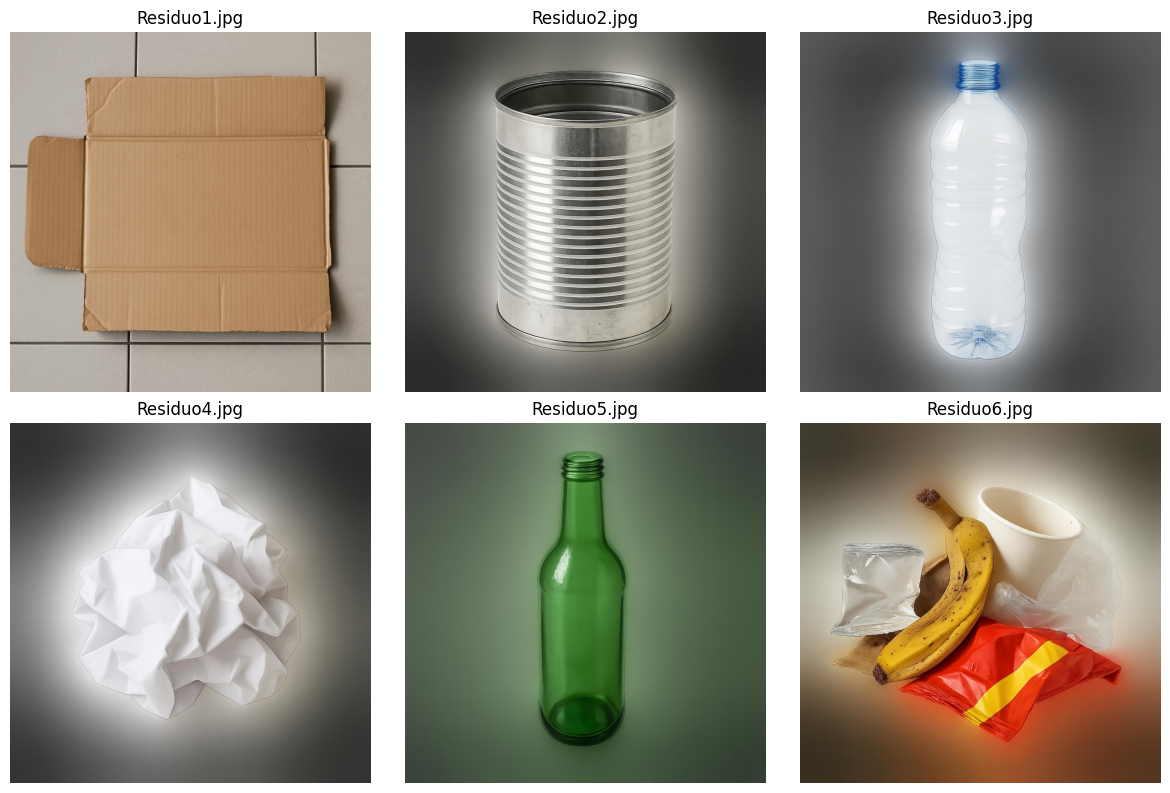

In [ ]:
INPUT_PATH = "input/"
image_paths = [
    "Residuo1.jpg", "Residuo2.jpg", "Residuo3.jpg",
    "Residuo4.jpg", "Residuo5.jpg", "Residuo6.jpg"
]

plt.figure(figsize=(12, 8))
for i, image_name in enumerate(image_paths):
    img = Image.open(os.path.join(INPUT_PATH, image_name))
    plt.subplot(2, 3, i + 1)
    plt.imshow(img)
    plt.title(image_name)
    plt.axis("off")

plt.tight_layout()
plt.show()


Se aplica una transformación del input equivalente a la utilizada en entrenamiento y validación.

In [ ]:
transform = transforms.Compose(
    [
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize([0.5] * 3, [0.5] * 3),
    ]
)

**Predicción**

In [ ]:
def predict_image(image_path):
    image = Image.open(image_path).convert("RGB")
    input_tensor = transform(image).unsqueeze(0).to(device)  # agrega batch dimension y lleva a device
    with torch.no_grad():
        output = model(input_tensor)
        probs = F.softmax(output, dim=1)
        confidence, pred_class = torch.max(probs, dim=1)
    return class_names[pred_class.item()], confidence.item()

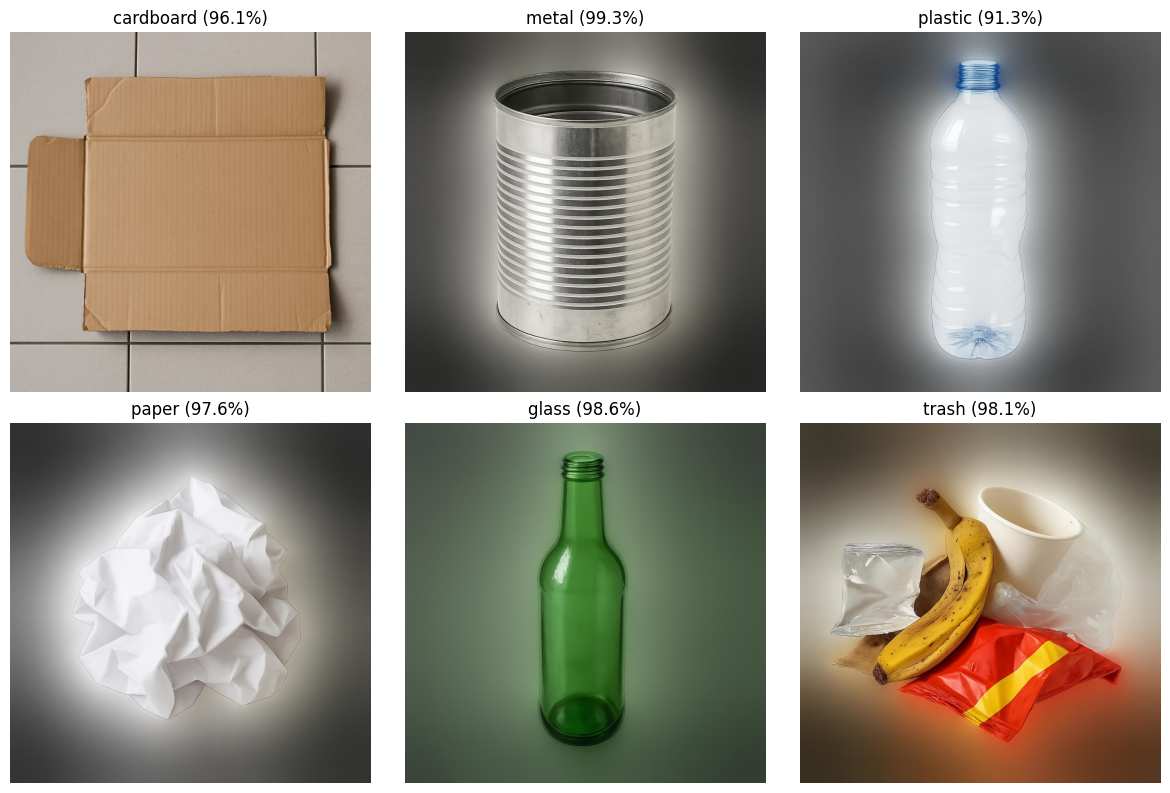

In [ ]:
plt.figure(figsize=(12, 8))
for i, image_name in enumerate(image_paths):
    image_path = os.path.join(INPUT_PATH, image_name)
    pred_class, confidence = predict_image(image_path)
    image = Image.open(image_path).convert("RGB")
    plt.subplot(2, 3, i + 1)
    plt.imshow(image)
    plt.title(f"{pred_class} ({confidence*100:.1f}%)")
    plt.axis("off")

plt.tight_layout()
plt.show()

### Conclusión:
Vemos que el resultado es 100% satisfatorio. El modelo clasifica bien todas las imágenes con confianzas altas.